# 8-node trial

## Imports

In [55]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import csv
from scipy.linalg import expm
from qiskit import QuantumCircuit
from qiskit.circuit.library import UnitaryGate
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
import random
from qiskit.quantum_info import Operator
import pandas as pd

## Network Graph & Adjacency matrix



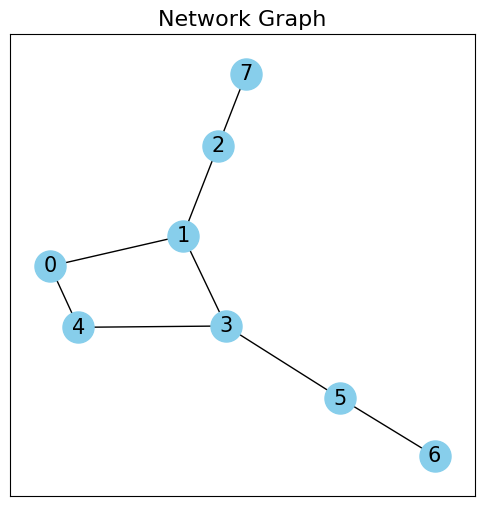

In [2]:

G = nx.Graph()
edges = [(0, 1), (1, 2), (1,3), (0,4), (4,3), (3,5), (5,6), (2,7) ] 
G.add_edges_from(edges)


plt.figure(figsize=(6, 6))
nx.draw_networkx(G, with_labels=True, node_color='skyblue', node_size=500, font_size=15)
plt.title("Network Graph", fontsize=16)
plt.show()

In [3]:

adj_matrix = nx.adjacency_matrix(G).toarray()
print("Adjacency Matrix:")
print(adj_matrix)


A = adj_matrix.astype(float)

Adjacency Matrix:
[[0 1 0 0 1 0 0 0]
 [1 0 1 1 0 0 0 0]
 [0 1 0 0 0 0 0 1]
 [0 1 0 0 1 1 0 0]
 [1 0 0 1 0 0 0 0]
 [0 0 0 1 0 0 1 0]
 [0 0 0 0 0 1 0 0]
 [0 0 1 0 0 0 0 0]]


## Simulated Quantum Random Walk


In [ ]:

def quantum_walk_t(A,t,n:int): 
    """
    Creates a quantum circuit for a quantum random walk at a specific time t starting at node n

    """
    # Intialize a quantum circuit
    num_target_qubits = int(np.log2(A.shape[0]))  # Infer target qubits from A
    qc = QuantumCircuit(num_target_qubits)  

    # Convert n to binary
    binary= format(n, f'0{num_target_qubits}b')
    
    # Encode starting node 
    for i, bit in enumerate(reversed(binary)):  # Reverse to match Qiskit's qubit indexing
        if bit == '1':
            qc.x(i)

    qc.barrier()

    # Calculate e^{-iAt}
    i = complex(0, 1)
    U_minus = expm(-i * A * t)  # e^{-iAt}


    qc.unitary(Operator(U_minus), range(num_target_qubits))

    qc.measure_all()

    return qc

def measure_quantum_circuit(qc, simulator: str):
    """
        Runs a simulation of a quantum circuit and returns counts at that point
    """ 
    sim = Aer.get_backend(simulator) 
    result = sim.run(qc).result()
    counts = result.get_counts()
    return counts

def add_max_and_avg(df):
    """
    Adds a row with the maximum value of each column (P-max) and the average of each column (P-avg).
    """
    # Find max values for each column (node)
    p_max = df.drop('Time', axis=1).max()
    
    # Find average values for each column (node)
    p_avg = df.drop('Time', axis=1).mean()

    # Add to Dataframe
    df.loc[len(df)] = ['P-max'] + p_max.tolist()
    df.loc[len(df)] = ['P-avg'] + p_avg.tolist()
    
    return df

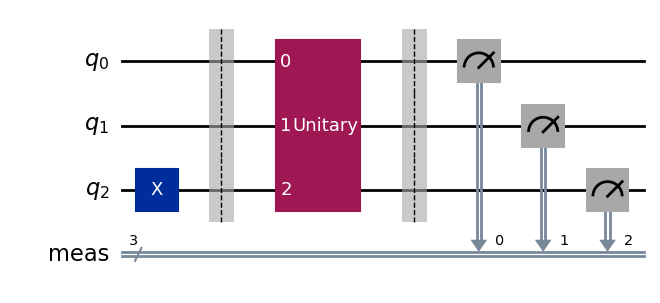

In [5]:
qc = quantum_walk_t(A,0,4)

qc.draw("mpl")

### Storing Data

The following cells creates a data frame that will allow us to store our data as each of the walks is produced

In [6]:
possible_nodes = ['000', '001', '010', '011', '100', '101', '110', '111']

columns = ['Time'] + possible_nodes
results_df = pd.DataFrame(columns=columns)

### Performing the walk

This __for loop__ will produce the quantum random walk in its entirety and store the results in a csv

In [7]:
for i in np.arange(0, 6, 0.5): 
    qc = quantum_walk_t(A,i,4)
    counts= measure_quantum_circuit(qc,'aer_simulator')
    possible_nodes= ['000', '001', '010', '011', '100','101','110','111']
    for node in possible_nodes: 
        if node not in counts:
            counts[node] = 0
    shots = 1024
    probabilities = {key: value / shots for key, value in counts.items()}
    # saving to dataframe
    row = [i] + [probabilities[node] for node in possible_nodes]
    results_df.loc[len(results_df)] = row

add_max_and_avg(results_df)
print(results_df)
results_df.to_csv("quantum_results_starting_on_node_4_8_nodes.csv")


     Time       000       001       010       011       100       101  \
0     0.0  0.000000  0.000000  0.000000  0.000000  1.000000  0.000000   
1     0.5  0.175781  0.049805  0.001953  0.149414  0.604492  0.018555   
2     1.0  0.225586  0.353516  0.064453  0.127930  0.111328  0.090820   
3     1.5  0.046875  0.472656  0.249023  0.000000  0.001953  0.071289   
4     2.0  0.000977  0.096680  0.368164  0.111328  0.023438  0.000000   
5     2.5  0.001953  0.009766  0.098633  0.045898  0.083984  0.128906   
6     3.0  0.068359  0.000000  0.029297  0.039062  0.054688  0.172852   
7     3.5  0.061523  0.172852  0.203125  0.104492  0.000977  0.062500   
8     4.0  0.029297  0.540039  0.167969  0.000977  0.026367  0.007812   
9     4.5  0.319336  0.397461  0.034180  0.129883  0.011719  0.004883   
10    5.0  0.328125  0.054688  0.009766  0.117188  0.371094  0.022461   
11    5.5  0.049805  0.001953  0.020508  0.005859  0.809570  0.000977   
12  P-max  0.328125  0.540039  0.368164  0.149414  

## Real Quantum Random Walk

The following cell prepares the environment to be able to submit jobs to the least busy service on the IBM quantum platform

In [9]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

 
QiskitRuntimeService.save_account(
  token= "",
  channel="ibm_quantum",
  overwrite='true'
)

service = QiskitRuntimeService()

backend = service.least_busy(simulator=False, operational=True)

### Additional Functions

In [ ]:
def quantum_walk_optimized_circuit(qc): 
    '''
    Translate our circuit to an assembled and optimized circuit that can be run on real hardware , minimizing two qubit gates and only using 1 and 2 qubit gates. 
    '''
    pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
    assembled_circuit = pm.run(qc)
 
    return assembled_circuit

def measure_quantum_circuit_real_counts(assembled_circuit, backend):


    sampler = Sampler(mode=backend)
    job = sampler.run([(assembled_circuit)])
    print(f">>> Job ID: {job.job_id()}")
    print(f">>> Job Status: {job.status()}")
    job.wait_for_final_state()
    print(f">>> Job Status: {job.status()}")
    result = job.result()

    pub_result = result[0]
    counts = pub_result.data.meas.get_counts()
    return counts
    

### Difference in circuits

In these next two cells we can observe the difference in circuit complexity and depth between our created circuit that is processed by the simulator and the actual quantum processor.

In [54]:
qc = quantum_walk_t(A,1,4)
print("The depth of the simulated circuit is ", qc.depth())

qc = quantum_walk_t(A,1,4)
assembled_circuit = quantum_walk_optimized_circuit(qc)
print("The depth of the real submission circuit is ", assembled_circuit.depth())

The depth of the simulated circuit is  3
The depth of the real submission circuit is  146


On the next two cells we can see the difference between them once we plot them. 

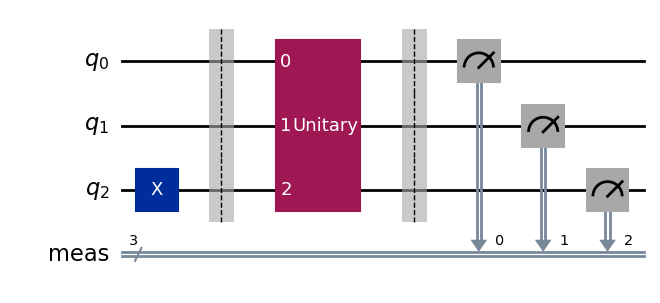

In [56]:
# Theoretical circuit

qc = quantum_walk_t(A,1,4)
qc.draw("mpl")

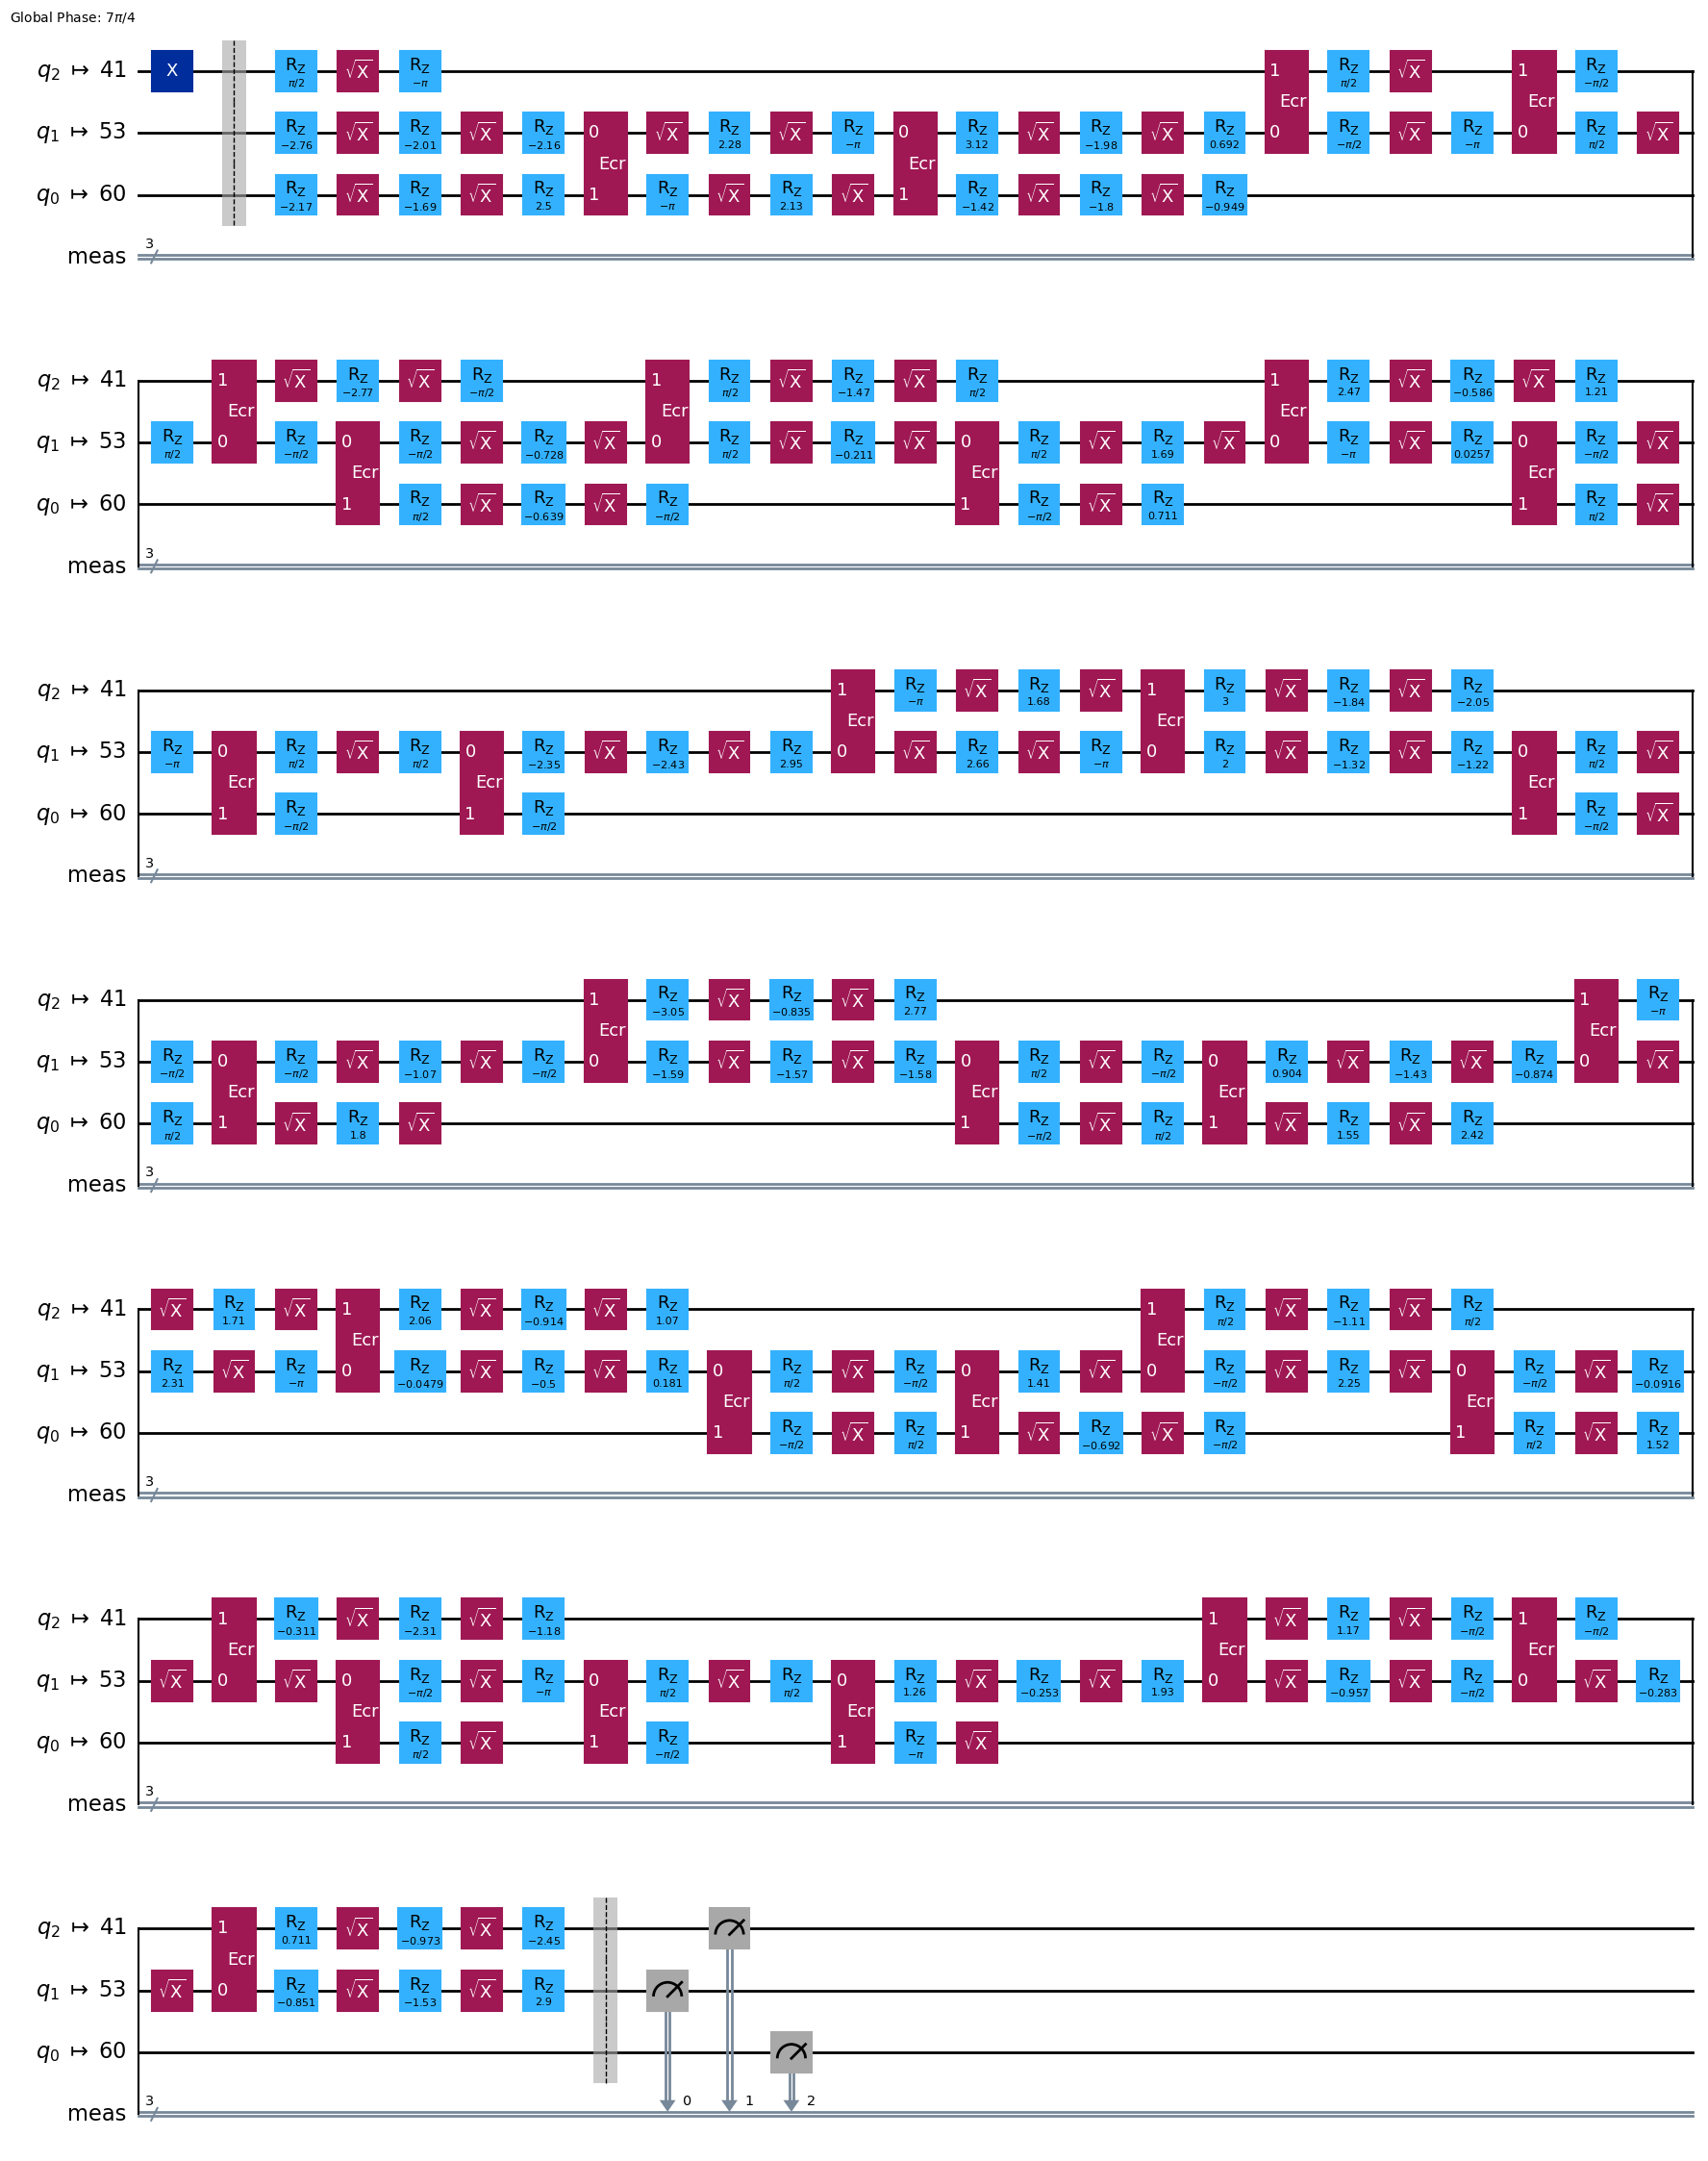

In [58]:
# Quantum assembled and optimized
qc = quantum_walk_t(A,1,4)
assembled_circuit = quantum_walk_optimized_circuit(qc)
assembled_circuit.draw("mpl",idle_wires=False)

Finally we submit our optimized and assembled circuit to IBM hardware, producing one job per time measurement

In [12]:
results_df_submission = pd.DataFrame(columns=columns)


for i in np.arange(0,6,0.5): 

    qc = quantum_walk_t(A,i,4)
    assembled_circuit1 = quantum_walk_optimized_circuit(qc) # assembling
    print ("Random walk at time "+str(i)+" done,assembled,optimized \n")
    counts=measure_quantum_circuit_real_counts(assembled_circuit1,backend) # sending to IBM

    total_shots = sum(counts.values())

    new_row = {'Time': i}

    for state in possible_nodes:
        count = counts.get(state, 0)  # Ensure missing states get 0
        new_row[state] = count / total_shots  # Normalize the count

    results_df_submission = pd.concat([results_df_submission, pd.DataFrame([new_row])], ignore_index=True)
    
    print ( "Done random walk at time"+str(i)+"\n \n")
    
add_max_and_avg(results_df_submission)
results_df_submission.to_csv("quantum_results_starting_on_node_4_8_nodes_IBM.csv")

Random walk at time 0.0 done,assembled,optimized 

>>> Job ID: cyvvyskq5bwg0083twcg
>>> Job Status: QUEUED
>>> Job Status: DONE


C:\Users\joseh\AppData\Local\Temp\ipykernel_28516\708979603.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df_submission = pd.concat([results_df_submission, pd.DataFrame([new_row])], ignore_index=True)


Done random walk at time0.0
 

Random walk at time 0.5 done,assembled,optimized 

>>> Job ID: cyvvz4cy2gd00088b0m0
>>> Job Status: QUEUED
>>> Job Status: DONE
Done random walk at time0.5
 

Random walk at time 1.0 done,assembled,optimized 

>>> Job ID: cyvvz8d38jq0008y2tfg
>>> Job Status: QUEUED
>>> Job Status: DONE
Done random walk at time1.0
 

Random walk at time 1.5 done,assembled,optimized 

>>> Job ID: cyvvzcd78z600082vye0
>>> Job Status: QUEUED
>>> Job Status: DONE
Done random walk at time1.5
 

Random walk at time 2.0 done,assembled,optimized 

>>> Job ID: cyvvzge78z600082vyfg
>>> Job Status: QUEUED
>>> Job Status: DONE
Done random walk at time2.0
 

Random walk at time 2.5 done,assembled,optimized 

>>> Job ID: cyvvzm678z600082vyg0
>>> Job Status: QUEUED
>>> Job Status: DONE
Done random walk at time2.5
 

Random walk at time 3.0 done,assembled,optimized 

>>> Job ID: cyvvzr738jq0008y2tq0
>>> Job Status: QUEUED
>>> Job Status: DONE
Done random walk at time3.0
 

Random walk at 